# Лабораторная работа № 1

## Сопоставление фотографий Прокудина-Горского

In [9]:
%matplotlib inline

import numpy as np
from skimage.io import imread, imshow, imsave
from skimage import img_as_float, img_as_ubyte

import matplotlib.pyplot as plt
import imageio

Функция, которая обрезает края картинок. Для 3 выбраных образцов оптимальная величиная среза 10% с каждой стороны.

In [2]:
def img_cut(img: imageio.core.util.Array, percent: float) -> imageio.core.util.Array:
    rows_count = img.shape[0]
    columns_count = img.shape[1]
    cut_row = np.ceil(rows_count * percent / 100).astype(int)
    cut_column = np.ceil(columns_count * percent / 100).astype(int)
    return img[cut_row: rows_count - cut_row, cut_column: columns_count - cut_column]

Поиск наиболее подходящего сдвига каналов относительного зеленого.

In [3]:
def channel_shift(green_channel: imageio.core.util.Array, 
                  other_channel: imageio.core.util.Array,
                  axis: int) -> float:
    max_corr = 0.
    max_shift = 0.
    for shift in range(-15, 16):
        other_channel_shift = np.roll(other_channel, shift, axis)
        corr = np.sum(green_channel * other_channel_shift)
        if corr > max_corr:
            max_corr = corr
            max_shift = shift
    return max_shift

Функция выравнивая трех компонент и соединения в цельную картинку.

In [4]:
def align(img: imageio.core.util.Array, cut_percent: float) -> imageio.core.util.Array:
    rows_count = img.shape[0]
    rows_count -= rows_count % 3
    
    channels = []
    channels.append(img[rows_count // 3 * 2: rows_count, :]) #red
    channels.append(img[rows_count // 3: rows_count // 3 * 2, :]) #green
    channels.append(img[:rows_count // 3, :]) #blue

    for i in range(len(channels)):
        channels[i] = img_as_float(img_cut(channels[i], cut_percent)) 
        
    blue_row_shift = channel_shift(channels[1], channels[2], axis=1)
    blue_column_shift = channel_shift(channels[1], channels[2], axis=0)
    red_row_shift = channel_shift(channels[1], channels[0], axis=1)
    red_column_shift = channel_shift(channels[1], channels[0], axis=0)
    
    red_channel_shift = np.roll(channels[0], red_row_shift, axis=1)
    red_channel_shift = np.roll(red_channel_shift, red_column_shift, axis=0)
    blue_channel_shift = np.roll(channels[2], blue_row_shift, axis=1)
    blue_channel_shift = np.roll(blue_channel_shift, blue_column_shift, axis=0)
    return np.dstack((red_channel_shift, channels[1], blue_channel_shift))
    

Соберем все три экзепляра в лист для удобства.

In [5]:
images = []
for i in range(1, 4):
    images.append(imread(f'{i}.jpg'))

Результат работы программы и одновременный вывод на экран всех образцов.

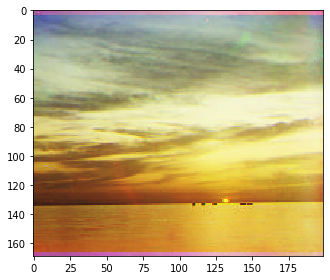

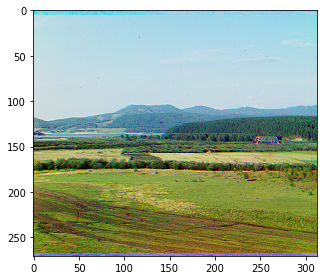

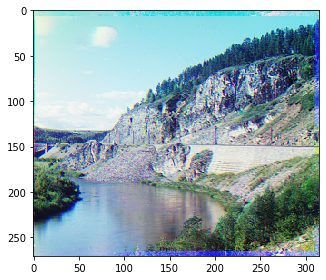

In [6]:
for img in images:
    imshow(align(img, 10))
    plt.pause(0.05)
plt.show()

### Бонус-функция, которая вычисляет координаты пикселя в синем и красном каналах (для Stepic.org).

P.S. Тесты на платформе не проходит, не понимаю почему.

In [10]:
def align(img, g_coord):
    row_g, col_g = g_coord
    
    rows_count = img.shape[0]
    rows_count -= rows_count % 3
    channels = []
    channels.append(img[rows_count // 3 * 2: rows_count, :]) #red
    channels.append(img[rows_count // 3: rows_count // 3 * 2, :]) #green
    channels.append(img[:rows_count // 3, :])
    
    for i in range(len(channels)):
        channels[i] = img_as_float(img_cut(channels[i], 10)) 
    
    blue_row_shift = channel_shift(channels[1], channels[2], axis=1)
    blue_column_shift = channel_shift(channels[1], channels[2], axis=0)
    red_row_shift = channel_shift(channels[1], channels[0], axis=1)
    red_column_shift = channel_shift(channels[1], channels[0], axis=0)
    
    row_b = row_g - img.shape[0] // 3 - blue_column_shift
    col_b = col_g - blue_row_shift
    row_r = row_g + img.shape[0] // 3 - red_column_shift 
    col_r = col_g - red_row_shift
    
    return (row_b, col_b), (row_r, col_r)
